<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Prediction

# Background

West Nile Virus(WNV) is most commonly spread to humans through infected mosquitoes. Around 20% of the people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human case of the WNV was reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health(CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Due to the rising seasonal epidemic of the WNV in Chicago, an increasing number of people need medical attention. As such, there is a need for better mosquito control. However, the City of Chicago can only react to the new cases and spraying pesticide is costly and must be done regularly.

# Problem Statement

Build a classification model of at least 90% recall score to predict areas of the city where there are mosquitoes carrying the West Nile Virus. Optimise current mosquito control measures to effectively and efficiently tackle the mosquito problem and create a desirable cost-benefit analysis.

## This notebook consists of Modelling. Please refer to the relevant notebooks for the other parts.

### Contents:
- **Data Dictionary**
- **Data Cleaning** - *refer to part 1 Data Cleaning notebook*
- **Exploratory Data Analysis & Visualisaion** - *refer to part 2 EDA notebook*
- **Modelling**
- **Spray Analysis** - *refer to part 4 spray analysis and conclusion notebook*
- **Conclusion and Recommendations** - *refer to part 4 spray analysis and conclusion notebook*

# Data Dictionary

#### trap_trn_weather_sel_feat.csv, trap_test_weather_sel_feat.csv
*Contains only the features and target used for modelling

|Feature|Type|Description|
|---|---|---|
|**Address_w**|*float*|The weight assigned to address location based on the likelihood of wnv|
|**Month_w**|*float*|The weight assigned to month based on the likelihood of wnv|
|**Species_w**|*float*|The weight assigned to mosquito species based on the likelihood of wnv|
|**DewPoint_14daysavg**|*float*|The average DewPoint temperature of the past 14 days (units in Fahrenheit)|
|**WetBulb_14daysavg**|*float*|The average WetBulb temperature of the past 14 days (units in Fahrenheit)|
|**Tavg_14daysavg**|*float*|The average daily temperature of the past 14 days (units in Fahrenheit)|
|**Cool_14daysavg**|*float*|The average cooling temperature of the past 14 days (units in Fahrenheit)|
|**ResultSpeed_14daysavg**|*float*|The average resultant wind speed of the past 14 days (units in MPH)|
|**AvgSpeed_14daysavg**|*float*|The average daily wind speed of the past 14 days (units in MPH)|
|**PrecipTotal_14daysavg**|*float*|The average of the total precipitation of the past 14 days (units in inches)|
|**r_humidity_14daysavg**|*float*|The average relative humidity of the past 14 days (units in percentage)|
|**WnvPresent**|*int*|Label for presence of west nile virus in mosquito (0 indicates the absence of wvn and 1 indicates the presence of wnv)|

# Modelling

In [1]:
## List of selected features

sel_features = ['Address_w', 'Month_w', 'DewPoint_14daysavg',
                'r_humidity_14daysavg', 'Species_w', 'Cool_14daysavg', 'WetBulb_14daysavg',
                'PrecipTotal_14daysavg','ResultSpeed_14daysavg', 'AvgSpeed_14daysavg', 'Tavg_14daysavg'] 

#### Choice of evaluation metrics
Recall and ROC-AUC score were chosen. Recall was chosen because of the high importance to predict whether west nile virus is present. West nile virus has potential to cause harm to human and in some cases, it causes death and hence, missing this label should be avoided. Recall gives the percentage of how well our model can predict the west nile virus label. The higher the recall, the better the model performance. ROC-AUC which stands for Area Under Curve Receiver Operator Characteristic is area under the probability curve where the curve is plotted with True Positive Rate against the False Positive Rate. It measures how well our model is able to distinguish between the labels. ROC-AUC score was chosen as the secondary metric to ensure that the other label is not too poorly predicted and gives us the flexibility to adjust the probability boundary between the two labels. The higher the recall and ROC-AUC score and closer to 1, the better the model performance.

## Data Preparation

In [2]:
# Import libraries

import pandas as pd
import numpy as np

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing and data preparation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import RandomOverSampler

# For modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# For model evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, recall_score

# For identification of feature importance
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings(action = 'ignore')

In [3]:
# Set display settings for dataframe

pd.set_option('display.max_columns',90)
pd.set_option('display.max_rows',50)
pd.set_option('display.max_colwidth', 200)

In [4]:
# load train dataset with selected features

trap_trn_weather_sel_feat = pd.read_csv('data/trap_trn_weather_sel_feat.csv')

In [5]:
# Instantiate

## Transformer

### MinMaxScaler
mms = MinMaxScaler()


## Models

### Logistic Regression
LogReg = LogisticRegression(solver='liblinear')

### K-nearest Neighbors
knn = KNeighborsClassifier()

### Random Forest Classifier
rf_clf = RandomForestClassifier(random_state = 1)

### Adaptive Boosting Classifier
ad_clf = AdaBoostClassifier(random_state = 1)

### Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state = 1)

In [6]:
trap_trn_weather_sel_feat.head()

,Address_w,Month_w,DewPoint_14daysavg,r_humidity_14daysavg,Species_w,Cool_14daysavg,WetBulb_14daysavg,PrecipTotal_14daysavg,ResultSpeed_14daysavg,AvgSpeed_14daysavg,Tavg_14daysavg,WnvPresent,Address,Month
0,0.097297,0.0,45.285714,41.42716,0.055135,2.857143,54.142857,0.091429,8.214286,9.85,64.142857,0,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",5
1,0.097297,0.0,45.285714,41.42716,0.017883,2.857143,54.142857,0.091429,8.214286,9.85,64.142857,0,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",5
2,0.000000,0.0,45.285714,41.42716,0.017883,2.857143,54.142857,0.091429,8.214286,9.85,64.142857,0,"6200 North Mandell Avenue, Chicago, IL 60646, USA",5
3,0.114286,0.0,45.285714,41.42716,0.055135,2.857143,54.142857,0.091429,8.214286,9.85,64.142857,0,"7900 West Foster Avenue, Chicago, IL 60656, USA",5
4,0.114286,0.0,45.285714,41.42716,0.017883,2.857143,54.142857,0.091429,8.214286,9.85,64.142857,0,"7900 West Foster Avenue, Chicago, IL 60656, USA",5


In [7]:
# Split data with stratification to train and test datasets for modelling and evaluation

X_train, X_val, y_train, y_val = train_test_split(trap_trn_weather_sel_feat[sel_features], 
                                                  trap_trn_weather_sel_feat['WnvPresent'],
                                                  test_size = 0.3,
                                                  random_state = 1,
                                                  stratify = trap_trn_weather_sel_feat['WnvPresent'])

In [8]:
# Display number of rows of each class in train dataset

y_train.value_counts()

0    6968
1     386
Name: WnvPresent, dtype: int64

In [9]:
# Display number of rows of each class in test dataset

y_val.value_counts()

0    2987
1     165
Name: WnvPresent, dtype: int64

Imbalanced data between class 0 and class 1. Upsampling of class 1 in train dataset is required. 

Below are the upsampling techniques used:
- Oversampling of class 1 with replacement
- SMOTE

In [10]:
# Create a list to store the model performance

model_perf = []

### Modelling on data with oversampling of minority class with replacement

In [11]:
## Upsampling of minority class 1 to match with class 0 using resampling

# Combine the X and y for trainset for upsampling
df_train = pd.concat([X_train, y_train], axis=1)

#create two different dataframe of majority and minority class 
df_majority = df_train[df_train['WnvPresent']==0] 
df_minority = df_train[df_train['WnvPresent']==1] 

# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= y_train.value_counts().loc[0], # to match counts of majority class (i.e. class 0)
                                 random_state=1)  # reproducible results

# Print the info on the class 0 and 1
print('Number of rows and columns in class 0 for train dataset:')
print(df_majority.shape)
print('Number of rows and columns in class 1 for train dataset:')
print(df_minority_upsampled.shape)


# Combine majority class with upsampled minority class
train_upsampled = pd.concat([df_minority_upsampled, df_majority])

# Split X and y
X_train_re = train_upsampled.drop(['WnvPresent'], axis=1)
y_train_re = train_upsampled.WnvPresent

Number of rows and columns in class 0 for train dataset:
(6968, 12)
Number of rows and columns in class 1 for train dataset:
(6968, 12)


In [12]:
## Modelling with K Nearest Neighbors - MinMaxScaler

print('*KNN - MinMaxScaler*')

# Create Pipeline
pipe_mms_knn = Pipeline([
    ('mms', mms),
    ('knn', knn)
])

# Train model
pipe_mms_knn.fit(X_train_re, y_train_re)

# Recall score for train dataset
recall_score_mms_knn_train = recall_score(y_train_re, pipe_mms_knn.predict(X_train_re))
print(f'Recall_score for train: {recall_score_mms_knn_train}')

# Recall score for val dataset
recall_score_mms_knn_val = recall_score(y_val, pipe_mms_knn.predict(X_val))
print(f'Recall_score for val: {recall_score_mms_knn_val}')

# ROC-AUC score for train dataset
roc_auc_score_mms_knn_train = roc_auc_score(y_train, pipe_mms_knn.predict_proba(X_train)[:,1])
print(f'roc_auc_score for train: {roc_auc_score_mms_knn_train}')

# ROC-AUC score for val dataset
roc_auc_score_mms_knn_val = roc_auc_score(y_val, pipe_mms_knn.predict_proba(X_val)[:,1])
print(f'roc_auc_score for val: {roc_auc_score_mms_knn_val}')

# Append model score to 'model_perf' list
model_perf.append({'model': 'KNN (baseline)',
                   'management of imbalanced data':'oversampling of minority class using replacement',
                   'scaler': 'MinMaxScaler',
                   'Recall for train': recall_score_mms_knn_train,
                   'Recall for val': recall_score_mms_knn_val,
                   'ROC-AUC Score for train': roc_auc_score_mms_knn_train,
                   'ROC-AUC Score for val': roc_auc_score_mms_knn_val})

# Display Classification Metrics for val
print('\n')
print('Classification Report for val dataset')
print(classification_report(y_val, pipe_mms_knn.predict(X_val)))


*KNN - MinMaxScaler*
Recall_score for train: 1.0
Recall_score for val: 0.47878787878787876
roc_auc_score for train: 0.9716680398327215
roc_auc_score for val: 0.7128546935711315


Classification Report for val dataset
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2987
           1       0.16      0.48      0.24       165

    accuracy                           0.84      3152
   macro avg       0.56      0.67      0.57      3152
weighted avg       0.93      0.84      0.87      3152



In [13]:
## Modelling with LogisticRegression - MinMaxScaler

print('*LogReg - MinMaxScaler*')

# Create Pipeline
pipe_mms_logreg = Pipeline([
    ('mms', mms),
    ('LogReg', LogReg)
])

# Train model
pipe_mms_logreg.fit(X_train_re, y_train_re)

# Recall score for train dataset
recall_score_mms_logreg_train = recall_score(y_train_re, pipe_mms_logreg.predict(X_train_re))
print(f'Recall_score for train: {recall_score_mms_logreg_train}')

# Recall score for val dataset
recall_score_mms_logreg_val = recall_score(y_val, pipe_mms_logreg.predict(X_val))
print(f'Recall_score for val: {recall_score_mms_logreg_val}')

# ROC-AUC score for train dataset
roc_auc_score_mms_logreg_train = roc_auc_score(y_train, pipe_mms_logreg.predict_proba(X_train)[:,1])
print(f'roc_auc_score for train: {roc_auc_score_mms_logreg_train}')

# ROC-AUC score for val dataset
roc_auc_score_mms_logreg_val = roc_auc_score(y_val, pipe_mms_logreg.predict_proba(X_val)[:,1])
print(f'roc_auc_score for val: {roc_auc_score_mms_logreg_val}')

# Append model score to 'model_perf' list
model_perf.append({'model': 'LogReg',
                   'management of imbalanced data':'oversampling of minority class using replacement',
                   'scaler': 'MinMaxScaler',
                   'Recall for train': recall_score_mms_logreg_train,
                   'Recall for val': recall_score_mms_logreg_val,
                   'ROC-AUC Score for train': roc_auc_score_mms_logreg_train,
                   'ROC-AUC Score for val': roc_auc_score_mms_logreg_val})

# Display Classification Metrics for val
print('\n')
print('Classification Report for val dataset')
print(classification_report(y_val, pipe_mms_logreg.predict(X_val)))


*LogReg - MinMaxScaler*
Recall_score for train: 0.7570321469575201
Recall_score for val: 0.793939393939394
roc_auc_score for train: 0.8175999238562073
roc_auc_score for val: 0.8257246045997302


Classification Report for val dataset
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      2987
           1       0.13      0.79      0.23       165

    accuracy                           0.72      3152
   macro avg       0.56      0.76      0.53      3152
weighted avg       0.94      0.72      0.80      3152



In [14]:
## Modelling with Random Forest Classifier
# Note: no scaling is required

print('*Random Forest Classifier*')

# Instantiate
rf_clf = RandomForestClassifier(n_estimators=200, random_state=1)

# Train model
rf_clf.fit(X_train_re, y_train_re)

# Recall score for train dataset
recall_score_mms_rfclf_train = recall_score(y_train_re, rf_clf.predict(X_train_re))
print(f'Recall_score for train: {recall_score_mms_rfclf_train}')

# Recall score for val dataset
recall_score_rfclf_val = recall_score(y_val, rf_clf.predict(X_val))
print(f'Recall_score for val: {recall_score_rfclf_val}')

# ROC-AUC score for train dataset
roc_auc_score_rfclf_train = roc_auc_score(y_train, rf_clf.predict_proba(X_train)[:,1])
print(f'roc_auc_score for train: {roc_auc_score_rfclf_train}')

# ROC-AUC score for val dataset
roc_auc_score_rfclf_val = roc_auc_score(y_val, rf_clf.predict_proba(X_val)[:,1])
print(f'roc_auc_score for val: {roc_auc_score_rfclf_val}')

# Append model score to 'model_perf' list
model_perf.append({'model': 'Random Forest Classifier',
                   'management of imbalanced data':'oversampling of minority class using replacement',
                   'scaler': '-',
                   'Recall for train': recall_score_mms_rfclf_train,
                   'Recall for val': recall_score_rfclf_val,
                   'ROC-AUC Score for train': roc_auc_score_rfclf_train,
                   'ROC-AUC Score for val': roc_auc_score_rfclf_val})

# Display Classification Metrics for val
print('\n')
print('Classification Report for val dataset')
print(classification_report(y_val, rf_clf.predict(X_val)))


*Random Forest Classifier*
Recall_score for train: 0.9928243398392652
Recall_score for val: 0.2727272727272727
roc_auc_score for train: 0.9951041920727173
roc_auc_score for val: 0.7790557060393016


Classification Report for val dataset
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2987
           1       0.16      0.27      0.20       165

    accuracy                           0.89      3152
   macro avg       0.56      0.60      0.57      3152
weighted avg       0.92      0.89      0.90      3152



In [15]:
## Modelling with Adaptive Boosting Classifier
# Note: no scaling is required

print('*Adaptive Boosting Classifier*')

# Instantiate
ad_estimator = DecisionTreeClassifier(max_depth=1)
ad_clf = AdaBoostClassifier(base_estimator=ad_estimator, n_estimators=200, learning_rate=1.0, random_state=1)

# Train model
ad_clf.fit(X_train_re, y_train_re)

# Recall score for train dataset
recall_score_mms_adclf_train = recall_score(y_train_re, ad_clf.predict(X_train_re))
print(f'Recall_score for train: {recall_score_mms_adclf_train}')

# Recall score for val dataset
recall_score_adclf_val = recall_score(y_val, ad_clf.predict(X_val))
print(f'Recall_score for val: {recall_score_adclf_val}')

# ROC-AUC score for train dataset
roc_auc_score_adclf_train = roc_auc_score(y_train, ad_clf.predict_proba(X_train)[:,1])
print(f'roc_auc_score for train: {roc_auc_score_adclf_train}')

# ROC-AUC score for val dataset
roc_auc_score_adclf_val = roc_auc_score(y_val, ad_clf.predict_proba(X_val)[:,1])
print(f'roc_auc_score for val: {roc_auc_score_adclf_val}')

# Append model score to 'model_perf' list
model_perf.append({'model': 'Adaptive Boosting Classifier',
                   'management of imbalanced data':'oversampling of minority class using replacement',
                   'scaler': '-',
                   'Recall for train': recall_score_mms_adclf_train,
                   'Recall for val': recall_score_adclf_val,
                   'ROC-AUC Score for train': roc_auc_score_adclf_train,
                   'ROC-AUC Score for val': roc_auc_score_adclf_val})

# Display Classification Metrics for val
print('\n')
print('Classification Report for val dataset')
print(classification_report(y_val, ad_clf.predict(X_val)))

*Adaptive Boosting Classifier*
Recall_score for train: 0.8429965556831228
Recall_score for val: 0.793939393939394
roc_auc_score for train: 0.8915438005270578
roc_auc_score for val: 0.8459070111899036


Classification Report for val dataset
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      2987
           1       0.15      0.79      0.25       165

    accuracy                           0.75      3152
   macro avg       0.57      0.77      0.55      3152
weighted avg       0.94      0.75      0.82      3152



In [16]:
## Modelling with Gradient Boosting Classifier
# Note: no scaling is required

print('*Gradient Boosting Classifier*')

# Instantiate
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=1)

# Train model
gb_clf.fit(X_train_re, y_train_re)

# Recall score for train dataset
recall_score_mms_gbclf_train = recall_score(y_train_re, gb_clf.predict(X_train_re))
print(f'Recall_score for train: {recall_score_mms_gbclf_train}')

# Recall score for val dataset
recall_score_gbclf_val = recall_score(y_val, gb_clf.predict(X_val))
print(f'Recall_score for val: {recall_score_gbclf_val}')

# ROC-AUC score for train dataset
roc_auc_score_gbclf_train = roc_auc_score(y_train, gb_clf.predict_proba(X_train)[:,1])
print(f'roc_auc_score for train: {roc_auc_score_gbclf_train}')

# ROC-AUC score for val dataset
roc_auc_score_gbclf_val = roc_auc_score(y_val, gb_clf.predict_proba(X_val)[:,1])
print(f'roc_auc_score for val: {roc_auc_score_gbclf_val}')

# Append model score to 'model_perf' list
model_perf.append({'model': 'Gradient Boosting Classifier',
                   'management of imbalanced data':'oversampling of minority class using replacement',
                   'scaler': '-',
                   'Recall for train': recall_score_mms_gbclf_train,
                   'Recall for val': recall_score_gbclf_val,
                   'ROC-AUC Score for train': roc_auc_score_gbclf_train,
                   'ROC-AUC Score for val': roc_auc_score_gbclf_val})

# Display Classification Metrics for val
print('\n')
print('Classification Report for val dataset')
print(classification_report(y_val, gb_clf.predict(X_val)))

*Gradient Boosting Classifier*
Recall_score for train: 0.9421641791044776
Recall_score for val: 0.7575757575757576
roc_auc_score for train: 0.9281056480253178
roc_auc_score for val: 0.8507867425510546


Classification Report for val dataset
              precision    recall  f1-score   support

           0       0.98      0.79      0.88      2987
           1       0.17      0.76      0.28       165

    accuracy                           0.79      3152
   macro avg       0.58      0.78      0.58      3152
weighted avg       0.94      0.79      0.85      3152



### Modelling on imbalanced data with SMOTE

In [17]:
## Oversampling of minority class using SMOTE - Synthetic Minority Oversampling Technique

# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='not majority', random_state=1)

# Fit the model to generate the data.
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)


In [18]:
# Display the value counts of y_train and y_train_sm

print('Value counts of y_train i.e. before SMOTE')
print(y_train.value_counts())

print('\n')

print('Value counts of y_train_sm i.e. after SMOTE')
print(y_train_sm.value_counts())

Value counts of y_train i.e. before SMOTE
0    6968
1     386
Name: WnvPresent, dtype: int64


Value counts of y_train_sm i.e. after SMOTE
0    6968
1    6968
Name: WnvPresent, dtype: int64


In [19]:
## Modelling with LogisticRegression - SMOTE / MinMaxScaler

print('*LogReg - MinMaxScaler*')

# Create Pipeline
pipe_mms_logreg = Pipeline([
    ('mms', mms),
    ('LogReg', LogReg)
])

# Train model
pipe_mms_logreg.fit(X_train_sm, y_train_sm)

# Recall score for train dataset
recall_score_mms_logreg_train = recall_score(y_train_sm, pipe_mms_logreg.predict(X_train_sm))
print(f'Recall_score for train: {recall_score_mms_logreg_train}')

# Recall score for val dataset
recall_score_mms_logreg_val = recall_score(y_val, pipe_mms_logreg.predict(X_val))
print(f'Recall_score for val: {recall_score_mms_logreg_val}')

# ROC-AUC score for train dataset
roc_auc_score_mms_logreg_train = roc_auc_score(y_train, pipe_mms_logreg.predict_proba(X_train)[:,1])
print(f'roc_auc_score for train: {roc_auc_score_mms_logreg_train}')

# ROC-AUC score for val dataset
roc_auc_score_mms_logreg_val = roc_auc_score(y_val, pipe_mms_logreg.predict_proba(X_val)[:,1])
print(f'roc_auc_score for val: {roc_auc_score_mms_logreg_val}')

# Append model score to 'model_perf' list
model_perf.append({'model': 'LogReg',
                   'management of imbalanced data':'SMOTE',
                   'scaler': 'MinMaxScaler',
                   'Recall for train': recall_score_mms_logreg_train,
                   'Recall for val': recall_score_mms_logreg_val,
                   'ROC-AUC Score for train': roc_auc_score_mms_logreg_train,
                   'ROC-AUC Score for val': roc_auc_score_mms_logreg_val})

# Display Classification Metrics for val
print('\n')
print('Classification Report for val dataset')
print(classification_report(y_val, pipe_mms_logreg.predict(X_val)))


*LogReg - MinMaxScaler*
Recall_score for train: 0.7876004592422503
Recall_score for val: 0.793939393939394
roc_auc_score for train: 0.8173296282636241
roc_auc_score for val: 0.8241967718700226


Classification Report for val dataset
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      2987
           1       0.14      0.79      0.23       165

    accuracy                           0.72      3152
   macro avg       0.56      0.76      0.53      3152
weighted avg       0.94      0.72      0.80      3152



In [20]:
## Modelling with K Nearest Neighbors - SMOTE / MinMaxScaler

print('*KNN - MinMaxScaler*')

# Create Pipeline
pipe_mms_knn = Pipeline([
    ('mms', mms),
    ('knn', knn)
])

# Train model
pipe_mms_knn.fit(X_train_sm, y_train_sm)

# Recall score for train dataset
recall_score_mms_knn_train = recall_score(y_train_sm, pipe_mms_knn.predict(X_train_sm))
print(f'Recall_score for train: {recall_score_mms_knn_train}')

# Recall score for val dataset
recall_score_mms_knn_val = recall_score(y_val, pipe_mms_knn.predict(X_val))
print(f'Recall_score for val: {recall_score_mms_knn_val}')

# ROC-AUC score for train dataset
roc_auc_score_mms_knn_train = roc_auc_score(y_train, pipe_mms_knn.predict_proba(X_train)[:,1])
print(f'roc_auc_score for train: {roc_auc_score_mms_knn_train}')

# ROC-AUC score for val dataset
roc_auc_score_mms_knn_val = roc_auc_score(y_val, pipe_mms_knn.predict_proba(X_val)[:,1])
print(f'roc_auc_score for val: {roc_auc_score_mms_knn_val}')

# Append model score to 'model_perf' list
model_perf.append({'model': 'KNN',
                   'management of imbalanced data':'SMOTE',
                   'scaler': 'MinMaxScaler',
                   'Recall for train': recall_score_mms_knn_train,
                   'Recall for val': recall_score_mms_knn_val,
                   'ROC-AUC Score for train': roc_auc_score_mms_knn_train,
                   'ROC-AUC Score for val': roc_auc_score_mms_knn_val})

# Display Classification Metrics for val
print('\n')
print('Classification Report for val dataset')
print(classification_report(y_val, pipe_mms_knn.predict(X_val)))

*KNN - MinMaxScaler*
Recall_score for train: 0.8747129735935706
Recall_score for val: 0.44242424242424244
roc_auc_score for train: 0.9378498599073186
roc_auc_score for val: 0.7737955382414706


Classification Report for val dataset
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2987
           1       0.21      0.44      0.28       165

    accuracy                           0.88      3152
   macro avg       0.59      0.67      0.61      3152
weighted avg       0.93      0.88      0.90      3152



In [21]:
## Modelling with Random Forest Classifier - SMOTE
# Note: no scaling is required

print('*Random Forest Classifier*')

# Instantiate
rf_clf = RandomForestClassifier(n_estimators=200, random_state=1)

# Train model
rf_clf.fit(X_train_sm, y_train_sm)

# Recall score for train dataset
recall_score_rfclf_train = recall_score(y_train_sm, rf_clf.predict(X_train_sm))
print(f'Recall_score for train: {recall_score_rfclf_train}')

# Recall score for val dataset
recall_score_rfclf_val = recall_score(y_val, rf_clf.predict(X_val))
print(f'Recall_score for val: {recall_score_rfclf_val}')

# ROC-AUC score for train dataset
roc_auc_score_rfclf_train = roc_auc_score(y_train, rf_clf.predict_proba(X_train)[:,1])
print(f'roc_auc_score for train: {roc_auc_score_rfclf_train}')

# ROC-AUC score for val dataset
roc_auc_score_rfclf_val = roc_auc_score(y_val, rf_clf.predict_proba(X_val)[:,1])
print(f'roc_auc_score for val: {roc_auc_score_rfclf_val}')

# Append model score to 'model_perf' list
model_perf.append({'model': 'Random Forest Classifier',
                   'management of imbalanced data':'SMOTE',
                   'scaler': '-',
                   'Recall for train': recall_score_rfclf_train,
                   'Recall for val': recall_score_rfclf_val,
                   'ROC-AUC Score for train': roc_auc_score_rfclf_train,
                   'ROC-AUC Score for val': roc_auc_score_rfclf_val})

# Display Classification Metrics for val
print('\n')
print('Classification Report for val dataset')
print(classification_report(y_val, rf_clf.predict(X_val)))

*Random Forest Classifier*
Recall_score for train: 0.9879448909299655
Recall_score for val: 0.3090909090909091
roc_auc_score for train: 0.9860249370921399
roc_auc_score for val: 0.7943735987257916


Classification Report for val dataset
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2987
           1       0.17      0.31      0.22       165

    accuracy                           0.89      3152
   macro avg       0.57      0.61      0.58      3152
weighted avg       0.92      0.89      0.90      3152



In [22]:
## Modelling with Adaptive Boosting Classifier - SMOTE
# Note: no scaling is required

print('*Adaptive Boosting Classifier*')

# Instantiate
ad_estimator = DecisionTreeClassifier(max_depth=1)
ad_clf = AdaBoostClassifier(base_estimator=ad_estimator, n_estimators=200, learning_rate=1.0, random_state=1)

# Train model
ad_clf.fit(X_train_sm, y_train_sm)

# Recall score for train dataset
recall_score_adclf_train = recall_score(y_train_sm, ad_clf.predict(X_train_sm))
print(f'Recall_score for train: {recall_score_adclf_train}')

# Recall score for val dataset
recall_score_adclf_val = recall_score(y_val, ad_clf.predict(X_val))
print(f'Recall_score for val: {recall_score_adclf_val}')

# ROC-AUC score for train dataset
roc_auc_score_adclf_train = roc_auc_score(y_train, ad_clf.predict_proba(X_train)[:,1])
print(f'roc_auc_score for train: {roc_auc_score_adclf_train}')

# ROC-AUC score for val dataset
roc_auc_score_adclf_val = roc_auc_score(y_val, ad_clf.predict_proba(X_val)[:,1])
print(f'roc_auc_score for val: {roc_auc_score_adclf_val}')

# Append model score to 'model_perf' list
model_perf.append({'model': 'Adaptive Boosting Classifier',
                   'management of imbalanced data':'SMOTE',
                   'scaler': '-',
                   'Recall for train': recall_score_adclf_train,
                   'Recall for val': recall_score_adclf_val,
                   'ROC-AUC Score for train': roc_auc_score_adclf_train,
                   'ROC-AUC Score for val': roc_auc_score_adclf_val})

# Display Classification Metrics for val
print('\n')
print('Classification Report for val dataset')
print(classification_report(y_val, ad_clf.predict(X_val)))

*Adaptive Boosting Classifier*
Recall_score for train: 0.922646383467279
Recall_score for val: 0.6545454545454545
roc_auc_score for train: 0.8825790586723616
roc_auc_score for val: 0.8407665540574815


Classification Report for val dataset
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      2987
           1       0.19      0.65      0.30       165

    accuracy                           0.84      3152
   macro avg       0.58      0.75      0.60      3152
weighted avg       0.94      0.84      0.88      3152



In [23]:
## Modelling with Gradient Boosting Classifier - SMOTE
# Note: no scaling is required

print('*Gradient Boosting Classifier*')

# Instantiate
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=1)

# Train model
gb_clf.fit(X_train_sm, y_train_sm)

# Recall score for train dataset
recall_score_gbclf_train = recall_score(y_train_sm, gb_clf.predict(X_train_sm))
print(f'Recall_score for train: {recall_score_gbclf_train}')

# Recall score for val dataset
recall_score_gbclf_val = recall_score(y_val, gb_clf.predict(X_val))
print(f'Recall_score for val: {recall_score_gbclf_val}')

# ROC-AUC score for train dataset
roc_auc_score_gbclf_train = roc_auc_score(y_train, gb_clf.predict_proba(X_train)[:,1])
print(f'roc_auc_score for train: {roc_auc_score_gbclf_train}')

# ROC-AUC score for val dataset
roc_auc_score_gbclf_val = roc_auc_score(y_val, gb_clf.predict_proba(X_val)[:,1])
print(f'roc_auc_score for val: {roc_auc_score_gbclf_val}')

# Append model score to 'model_perf' list
model_perf.append({'model': 'Gradient Boosting Classifier',
                   'management of imbalanced data':'SMOTE',
                   'scaler': '-',
                   'Recall for train': recall_score_gbclf_train,
                   'Recall for val': recall_score_gbclf_val,
                   'ROC-AUC Score for train': roc_auc_score_gbclf_train,
                   'ROC-AUC Score for val': roc_auc_score_gbclf_val})

# Display Classification Metrics for val
print('\n')
print('Classification Report for val dataset')
print(classification_report(y_val, gb_clf.predict(X_val)))

*Gradient Boosting Classifier*
Recall_score for train: 0.9500574052812859
Recall_score for val: 0.5878787878787879
roc_auc_score for train: 0.9006334657918061
roc_auc_score for val: 0.8472917998194195


Classification Report for val dataset
              precision    recall  f1-score   support

           0       0.97      0.88      0.93      2987
           1       0.22      0.59      0.32       165

    accuracy                           0.87      3152
   macro avg       0.60      0.74      0.62      3152
weighted avg       0.94      0.87      0.89      3152



In [24]:
# Display summary of model performance
pd.DataFrame(model_perf)

,model,management of imbalanced data,scaler,Recall for train,Recall for val,ROC-AUC Score for train,ROC-AUC Score for val
0,KNN (baseline),oversampling of minority class using replacement,MinMaxScaler,1.000000,0.478788,0.971668,0.712855
1,LogReg,oversampling of minority class using replacement,MinMaxScaler,0.757032,0.793939,0.817600,0.825725
2,Random Forest Classifier,oversampling of minority class using replacement,-,0.992824,0.272727,0.995104,0.779056
3,Adaptive Boosting Classifier,oversampling of minority class using replacement,-,0.842997,0.793939,0.891544,0.845907
4,Gradient Boosting Classifier,oversampling of minority class using replacement,-,0.942164,0.757576,0.928106,0.850787
5,LogReg,SMOTE,MinMaxScaler,0.787600,0.793939,0.817330,0.824197
6,KNN,SMOTE,MinMaxScaler,0.874713,0.442424,0.937850,0.773796
7,Random Forest Classifier,SMOTE,-,0.987945,0.309091,0.986025,0.794374
8,Adaptive Boosting Classifier,SMOTE,-,0.922646,0.654545,0.882579,0.840767
9,Gradient Boosting Classifier,SMOTE,-,0.950057,0.587879,0.900633,0.847292


Adaboost model with oversampling of minority class using replacement gives the best performance with highest recall score of 79% and ROC-AUC score of 85%. Hyperparameter tuning was then performed to optimise the model. 

### Hyperparameter tuning

In [25]:
## Modelling with Adaptive Boosting Classifier with GridSearchCV - RandomOverSampler / MinMaxScaler

print('*Adaptive Boosting Classifier with GridSearchCV - RandomOverSampler / MinMaxScaler*')

# Instatiate
ros = RandomOverSampler()
mms = MinMaxScaler()
ad_clf = AdaBoostClassifier()
dt2_2 = DecisionTreeClassifier(max_depth=2, class_weight={0:1,1:2})
dt2_3 = DecisionTreeClassifier(max_depth=2, class_weight={0:1,1:3})
dt2_4 = DecisionTreeClassifier(max_depth=2, class_weight={0:1,1:4})

# Create Pipeline

pipe_ros_mms_adclf = imbpipeline(steps =[['ros', ros],
                                         ['mms', mms],
                                         ['ad_clf', ad_clf]])


# Set testing params
pipe_ros_mms_adclf_params = {'ros__sampling_strategy': ['not majority'],
                             'ros__random_state': [1],
                             'ad_clf__base_estimator': [dt2_4], #[dt2_2, dt2_3, dt2_4]
                             'ad_clf__learning_rate': [0.01], #[0.01, 0.05]
                             'ad_clf__n_estimators': [100], #[50, 100, 200]
                             }
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

                            
# Set GridSearchCV
pipe_ros_mms_adclf_gs = GridSearchCV(pipe_ros_mms_adclf, pipe_ros_mms_adclf_params, cv=kf, scoring='recall') 

# Train model
pipe_ros_mms_adclf_gs.fit(X_train, y_train)

# Recall score for train dataset
recall_score_adclf_gs_train = recall_score(y_train, pipe_ros_mms_adclf_gs.predict(X_train))
print(f'Recall_score for train: {recall_score_adclf_gs_train}')

# Recall score for val dataset
recall_score_adclf_gs_val = recall_score(y_val, pipe_ros_mms_adclf_gs.predict(X_val))
print(f'Recall_score for val: {recall_score_adclf_gs_val}')

# ROC-AUC score for train dataset
roc_auc_score_adclf_gs_train = roc_auc_score(y_train, pipe_ros_mms_adclf_gs.predict_proba(X_train)[:,1])
print(f'roc_auc_score for train: {roc_auc_score_adclf_gs_train}')

# ROC-AUC score for val dataset
roc_auc_score_mms_adclf_gs_val = roc_auc_score(y_val, pipe_ros_mms_adclf_gs.predict_proba(X_val)[:,1])
print(f'roc_auc_score for val: {roc_auc_score_mms_adclf_gs_val}')

# Append model score to 'model_perf' list
model_perf.append({'model': 'Adaptive Boosting Classifier with hyperparameter tuning',
                   'management of imbalanced data':'oversampling of minority class using replacement',
                   'scaler': 'MinMaxScaler',
                   'Recall for train': recall_score_adclf_gs_train,
                   'Recall for val': recall_score_adclf_gs_val,
                   'ROC-AUC Score for train': roc_auc_score_adclf_gs_train,
                   'ROC-AUC Score for val': roc_auc_score_mms_adclf_gs_val})

# Display Classification Metrics for val
print('\n')
print('Classification Report for val dataset')
print(classification_report(y_val, pipe_ros_mms_adclf_gs.predict(X_val)))

*Adaptive Boosting Classifier with GridSearchCV - RandomOverSampler / MinMaxScaler*
Recall_score for train: 0.9870466321243523
Recall_score for val: 0.9636363636363636
roc_auc_score for train: 0.8536490648590447
roc_auc_score for val: 0.8379766868551602


Classification Report for val dataset
              precision    recall  f1-score   support

           0       1.00      0.43      0.60      2987
           1       0.09      0.96      0.16       165

    accuracy                           0.46      3152
   macro avg       0.54      0.70      0.38      3152
weighted avg       0.95      0.46      0.58      3152



In [26]:
# Display best parameters for our model
pipe_ros_mms_adclf_gs.best_params_

{'ad_clf__base_estimator': DecisionTreeClassifier(class_weight={0: 1, 1: 4}, max_depth=2),
 'ad_clf__learning_rate': 0.01,
 'ad_clf__n_estimators': 100,
 'ros__random_state': 1,
 'ros__sampling_strategy': 'not majority'}

## Summary of model performance

In [27]:
# Display summary of model performance with tuned model
pd.DataFrame(model_perf)

,model,management of imbalanced data,scaler,Recall for train,Recall for val,ROC-AUC Score for train,ROC-AUC Score for val
0,KNN (baseline),oversampling of minority class using replacement,MinMaxScaler,1.000000,0.478788,0.971668,0.712855
1,LogReg,oversampling of minority class using replacement,MinMaxScaler,0.757032,0.793939,0.817600,0.825725
2,Random Forest Classifier,oversampling of minority class using replacement,-,0.992824,0.272727,0.995104,0.779056
3,Adaptive Boosting Classifier,oversampling of minority class using replacement,-,0.842997,0.793939,0.891544,0.845907
4,Gradient Boosting Classifier,oversampling of minority class using replacement,-,0.942164,0.757576,0.928106,0.850787
5,LogReg,SMOTE,MinMaxScaler,0.787600,0.793939,0.817330,0.824197
6,KNN,SMOTE,MinMaxScaler,0.874713,0.442424,0.937850,0.773796
7,Random Forest Classifier,SMOTE,-,0.987945,0.309091,0.986025,0.794374
8,Adaptive Boosting Classifier,SMOTE,-,0.922646,0.654545,0.882579,0.840767
9,Gradient Boosting Classifier,SMOTE,-,0.950057,0.587879,0.900633,0.847292


The tuned model achieved a high recall score of 96% with good ROC-AUC score of above 80%. 

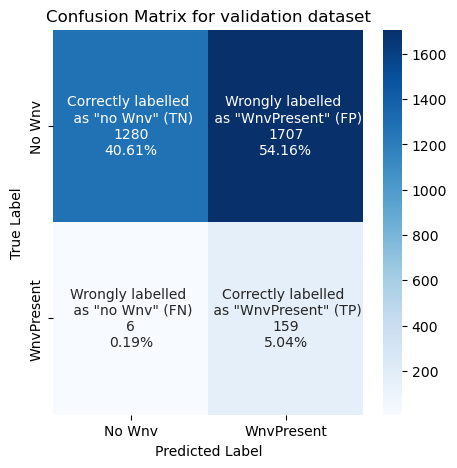

In [28]:
# Confusion Matrix for test dataset using best model after hyperparameter tuning

y_pred = pipe_ros_mms_adclf_gs.predict(X_val)

plt.figure(figsize =(5,5))

cf_matrix = confusion_matrix(y_val, y_pred)

group_names = ['Correctly labelled \n as "no Wnv" (TN)','Wrongly labelled \n as "WnvPresent" (FP)',
               'Wrongly labelled \n as "no Wnv" (FN)','Correctly labelled \n as "WnvPresent" (TP)']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

plt.title('Confusion Matrix for validation dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=(0.5,1.5),labels=('No Wnv','WnvPresent'))
plt.yticks(ticks=(0.5,1.5),labels=('No Wnv','WnvPresent'))

plt.show()

Our focus is to correctly predict the positive labels 'Presence of WNV'. Out of the 165 positive observations, 159 of them are correctly predicted. This shows that our model can predict the west nile virus label well on unseen validation dataset.

In [29]:
# Display feature importances
pd.DataFrame(pipe_ros_mms_adclf_gs.best_estimator_[2].feature_importances_, 
             index=sel_features).sort_values(by=0, ascending=False)

,0
Month_w,0.431371
Address_w,0.192144
WetBulb_14daysavg,0.148770
Species_w,0.102627
DewPoint_14daysavg,0.036622
r_humidity_14daysavg,0.029461
Tavg_14daysavg,0.028947
ResultSpeed_14daysavg,0.009898
Cool_14daysavg,0.008272
AvgSpeed_14daysavg,0.007560


The top 3 features are 'Month', 'Address' and average 'WetBulb' temperature of the past 14 days. These are expected and the location and seasonality place an importance in the mosquito breeding and activities.

## Prediction of potential areas for spray

Steps taken to use our model to predict the potential areas with mosquitoes with the presence of WNV

In [30]:
# Group the dataset by location and month
address_month_df = trap_trn_weather_sel_feat.groupby(['Address','Month']).mean()
address_month_df.head(15)

Address_w  \
Address                                                Month              
1000 East 67th Street, Chicago, IL 60637, USA          5       0.031250   
                                                       6       0.031250   
                                                       7       0.031250   
                                                       8       0.031250   
                                                       9       0.031250   
                                                       10      0.031250   
1000 North Central Park Avenue, Chicago, IL 60651, USA 5       0.063492   
                                                       6       0.063492   
                                                       7       0.063492   
                                                       8       0.063492   
                                                       9       0.063492   
                                                       10      0.063492   
1000 South California Avenue, Chicago, IL 60612, USA   6       0.000000   
                                                       7       0.000000   
                                                       8       0.000000   

                                                               Month_w  \
Address                                                Month             
1000 East 67th Street, Chicago, IL 60637, USA          5      0.000000   
                                                       6      0.000637   
                                                       7      0.017652   
                                                       8      0.100507   
                                                       9      0.056357   
                                                       10     0.007246   
1000 North Central Park Avenue, Chicago, IL 60651, USA 5      0.000000   
                                                       6      0.000637   
                                                       7      0.017652   
                                                       8      0.100507   
                                                       9      0.056357   
                                                       10     0.007246   
1000 South California Avenue, Chicago, IL 60612, USA   6      0.000637   
                                                       7      0.017652   
                                                       8      0.100507   

                                                              DewPoint_14daysavg  \
Address                                                Month                       
1000 East 67th Street, Chicago, IL 60637, USA          5               45.785714   
                                                       6               53.565217   
                                                       7               60.497696   
                                                       8               61.224490   
                                                       9               56.295918   
                                                       10              53.000000   
1000 North Central Park Avenue, Chicago, IL 60651, USA 5               45.785714   
                                                       6               53.022321   
                                                       7               61.260317   
                                                       8               60.616327   
                                                       9               56.288360   
                                                       10              53.000000   
1000 South California Avenue, Chicago, IL 60612, USA   6               58.357143   
                                                       7               57.666667   
                                                       8               62.125000   

                                                              r_humidity_14daysavg  \
Address     

In [31]:
# Predict the probability of the presence of wnv using our model

address_month_df['wnv_prob'] = pipe_ros_mms_adclf_gs.predict_proba(address_month_df[sel_features])[:,1]

In [32]:
# df with address and month with the wnv probability higher than 0.5

address_mth_wnv = address_month_df[address_month_df.wnv_prob >= 0.5][['wnv_prob']]
address_mth_wnv.reset_index(level=0, inplace=True)
address_mth_wnv.reset_index(level=0, inplace=True)
address_mth_wnv.head(10)

,Month,Address,wnv_prob
0,7,"1000 East 67th Street, Chicago, IL 60637, USA",0.551250
1,8,"1000 East 67th Street, Chicago, IL 60637, USA",0.722570
2,9,"1000 East 67th Street, Chicago, IL 60637, USA",0.632945
3,7,"1000 North Central Park Avenue, Chicago, IL 60651, USA",0.622091
4,8,"1000 North Central Park Avenue, Chicago, IL 60651, USA",0.804733
5,9,"1000 North Central Park Avenue, Chicago, IL 60651, USA",0.700383
6,7,"1000 West 95th Street, Chicago, IL 60643, USA",0.540088
7,8,"1000 West 95th Street, Chicago, IL 60643, USA",0.722339
8,7,"1100 North Artesian Avenue, Chicago, IL 60622, USA",0.551250
9,8,"1100 North Artesian Avenue, Chicago, IL 60622, USA",0.780859


In [33]:
# Display the unique number of address with likelihood of mosquitoes with wnv
address_mth_wnv['Address'].nunique()

98

Using our model, we predict that 98 areas out of 138 will likely to have mosquitoes with west nile virus. 

In [34]:
# Display the number of address with likelihood of mosquitoes with wnv by month
address_mth_wnv.groupby(by='Month')['wnv_prob'].count()

Month
7     91
8     98
9     87
10     7
Name: wnv_prob, dtype: int64

The month of August have the highest number of areas with likelihood of mosquitoes with wnv.

In [35]:
# df with address and the wnv presence probability for the respective months

address_wvn_by_mth=address_mth_wnv[['Address','Month','wnv_prob']].pivot_table(index=['Address'],
                                                           columns='Month',
                                                           values='wnv_prob').reset_index()
address_wvn_by_mth

Month,Address,7,8,9,10
0,"1000 East 67th Street, Chicago, IL 60637, USA",0.551250,0.722570,0.632945,NaN
1,"1000 North Central Park Avenue, Chicago, IL 60651, USA",0.622091,0.804733,0.700383,NaN
2,"1000 West 95th Street, Chicago, IL 60643, USA",0.540088,0.722339,NaN,NaN
3,"1100 North Artesian Avenue, Chicago, IL 60622, USA",0.551250,0.780859,0.688358,NaN
4,"1100 Roosevelt Road, Chicago, IL 60608, USA",0.544875,0.711354,0.616219,NaN
...,...,...,...,...,...
93,"South Stony Island Avenue, Chicago, IL, USA",0.551250,0.780859,0.688358,NaN
94,"South Torrence Avenue, Chicago, IL, USA",NaN,0.669479,NaN,NaN
95,"South Vincennes Avenue, Chicago, IL, USA",0.551250,0.780859,0.681891,NaN
96,"University of Illinois at Chicago, 1100 South Ashland Avenue, Chicago, IL 60607, USA",0.551250,0.769296,0.686060,NaN


## Kaggle submission

In [36]:
# laod dataset with test and selected features
trap_test_weather_sel_feat = pd.read_csv('data/trap_test_weather_sel_feat.csv')

In [37]:
# Add Id to df for Kaggle Submission
kaggle_sub = trap_test_weather_sel_feat[['Id']]

# Tabulate the probability for Kaggle submission
kaggle_sub['WnvPresent'] = pipe_ros_mms_adclf_gs.predict(trap_test_weather_sel_feat[sel_features])

# Save to CSV
kaggle_sub.to_csv('data/kaggle_submission.csv', index=False)

Note: Project was based on recall score optimisation and not ROC-AUC score.

Submission on 16 Dec 2022:
- Private = 0.61249
- Public = 0.62371
